## Using Deep Neural Networks for Prediction

We will start by selecting a reasonable number of features using a sklearn pipeline, then we will try to train simple bechmark neural networks. 

### Feature selection pipeline

Let's select best features after collecting up to 2-grams.


In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_NNet1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,2), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
    
])


In [2]:
import pickle
# Load Training and Validation sets
disk = "D:\Data_science\GitHub\Predictive-Modeling-510k-decision-time"
# Validation set 
with open(disk+"\X_val.pkl","rb") as f:
    X_val=pickle.load(f)

with open(disk+"\y_val.pkl","rb") as f:
    y_val=pickle.load(f)
    
# Training set (Locked down)
with open(disk+"\X_train.pkl","rb") as f:
    X_train=pickle.load(f)

with open(disk+"\y_train.pkl","rb") as f:
    y_train=pickle.load(f) 

In [3]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_NNet = pipeline510k_NNet1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_NNet = pipeline510k_NNet1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 1.3333333333333333 minutes.
Completed processing X_val in: 0.31666666666666665 minutes.


In [4]:
print(X_train_trans_NNet.shape)
print(X_val_trans_NNet.shape)
print(type(X_train_trans_NNet))
print(type(X_val_trans_NNet))

(32275, 524290)
(15899, 524290)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [12]:
from sklearn.metrics import median_absolute_error
filterwarnings("ignore")

n_features_list = [300,5000,10000,20000,50000,100000,200000,400000,500000]
mae_list = []
time_list = []

for n_features in n_features_list:
    print("Training model using "+ str(n_features)+ " features.")
    
    # Testing feature selection based on training set
    Xt = SelectKBest(f_regression,n_features).fit(X_train_trans_NNet,y_train).transform(X_train_trans_NNet)
    Xv = SelectKBest(f_regression,n_features).fit(X_train_trans_NNet,y_train).transform(X_val_trans_NNet)

    start = datetime.datetime.now()
    
    # Fixed model structure 
    from keras import models, metrics, layers
  
    network1 = models.Sequential()
    network1.add(layers.Dense(8,activation="relu", input_shape = (Xt.shape[1],)))
    network1.add(layers.Dense(16,activation="relu"))
    network1.add(layers.Dense(8,activation="relu"))
    network1.add(layers.Dense(1))
    network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
    history_net1 = network1.fit(Xt,np.log(y_train),  
                                 epochs=10,batch_size=200,validation_split= 0.3)
    preds = network1.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(n_features) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: "+ str(mae) + " features.")
    print("*" * 100)


Training model using 300 features.
Train on 22592 samples, validate on 9683 samples
Epoch 1/10
22592/22592 [==============================] - 0s 19us/step - loss: 1.0961 - mean_absolute_error: 1.0961 - val_loss: 0.7426 - val_mean_absolute_error: 0.7426
Epoch 2/10
22592/22592 [==============================] - 0s 10us/step - loss: 0.7111 - mean_absolute_error: 0.7111 - val_loss: 0.7013 - val_mean_absolute_error: 0.7013
Epoch 3/10
22592/22592 [==============================] - 0s 9us/step - loss: 0.6825 - mean_absolute_error: 0.6825 - val_loss: 0.6892 - val_mean_absolute_error: 0.6892
Epoch 4/10
22592/22592 [==============================] - 0s 10us/step - loss: 0.6634 - mean_absolute_error: 0.6634 - val_loss: 0.6627 - val_mean_absolute_error: 0.6627
Epoch 5/10
22592/22592 [==============================] - 0s 9us/step - loss: 0.6471 - mean_absolute_error: 0.6471 - val_loss: 0.6492 - val_mean_absolute_error: 0.6492
Epoch 6/10
22592/22592 [==============================] - 0s 10us/step - 

22592/22592 [==============================] - 11s 469us/step - loss: 0.9720 - mean_absolute_error: 0.9720 - val_loss: 0.6274 - val_mean_absolute_error: 0.6274
Epoch 2/10
22592/22592 [==============================] - 11s 471us/step - loss: 0.5549 - mean_absolute_error: 0.5549 - val_loss: 0.5788 - val_mean_absolute_error: 0.5788
Epoch 3/10
22592/22592 [==============================] - 10s 450us/step - loss: 0.4602 - mean_absolute_error: 0.4602 - val_loss: 0.5534 - val_mean_absolute_error: 0.5534
Epoch 4/10
22592/22592 [==============================] - 10s 455us/step - loss: 0.3989 - mean_absolute_error: 0.3989 - val_loss: 0.5513 - val_mean_absolute_error: 0.5513
Epoch 5/10
22592/22592 [==============================] - 10s 437us/step - loss: 0.3531 - mean_absolute_error: 0.3531 - val_loss: 0.5498 - val_mean_absolute_error: 0.5498
Epoch 6/10
22592/22592 [==============================] - 10s 441us/step - loss: 0.3212 - mean_absolute_error: 0.3212 - val_loss: 0.5514 - val_mean_absolute

Epoch 2/10
22592/22592 [==============================] - 89s 4ms/step - loss: 3.8173 - mean_absolute_error: 3.8173 - val_loss: 3.3884 - val_mean_absolute_error: 3.3884
Epoch 3/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.9152 - mean_absolute_error: 0.9152 - val_loss: 0.6038 - val_mean_absolute_error: 0.6038
Epoch 4/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.5171 - mean_absolute_error: 0.5171 - val_loss: 0.5854 - val_mean_absolute_error: 0.5854
Epoch 5/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.3687 - mean_absolute_error: 0.3687 - val_loss: 0.5729 - val_mean_absolute_error: 0.5729
Epoch 6/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.2909 - mean_absolute_error: 0.2909 - val_loss: 0.5677 - val_mean_absolute_error: 0.5677
Epoch 7/10
22592/22592 [==============================] - 89s 4ms/step - loss: 0.2393 - mean_absolute_error: 0.2393 - val_loss: 0.5702 - val_mean_absolute_

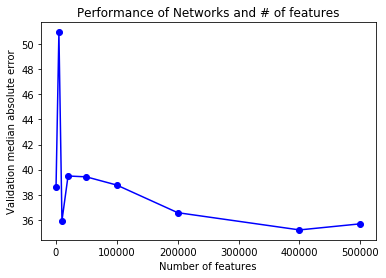

In [22]:
import matplotlib.pyplot as plt
plt.plot(n_features_list, mae_list, marker = "o", c = "b")
plt.title("Performance of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Validation median absolute error")
plt.show()

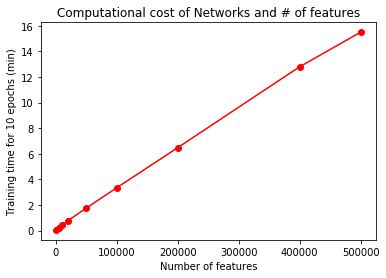

In [24]:
plt.plot(n_features_list, time_list, marker = "o", c = "r")
plt.title("Computational cost of Networks and # of features")
plt.xlabel("Number of features")
plt.ylabel("Training time for 10 epochs (min)")
plt.show()

We will use 10000 features since this provides the best performance in a reasonable computational cost.

### Bechmark Neural Networks


In [25]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_NNet1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2*(2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,2), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()), # Scale the features
    ("dim_red", SelectKBest(f_regression,10000))
])


In [ ]:
import datetime
from warnings import filterwarnings
import numpy as np

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_NNet = pipeline510k_NNet1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_NNet = pipeline510k_NNet1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

In [ ]:
print(X_train_trans_NNet.shape)
print(X_val_trans_NNet.shape)
print(type(X_train_trans_NNet))
print(type(X_val_trans_NNet))

In [31]:
from keras import models, metrics, layers
# Note that csr type of sparse matrix runs significantly faster in keras neural network implementation

network1 = models.Sequential()
network1.add(layers.Dense(16,activation="relu", input_shape = (X_train_trans_NNet.shape[1],)))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(16,activation="relu"))
network1.add(layers.Dense(1))
network1.compile(optimizer= "adam", loss= "mean_absolute_error", metrics= [metrics.mean_absolute_error])
history_net1 = network1.fit(X_train_trans_NNet,np.log(y_train),  
                             epochs=10,batch_size=200,validation_split= 0.3)

Train on 22592 samples, validate on 9683 samples
Epoch 1/10
22592/22592 [==============================] - 3s 127us/step - loss: 0.9452 - mean_absolute_error: 0.9452 - val_loss: 0.6251 - val_mean_absolute_error: 0.6251
Epoch 2/10
22592/22592 [==============================] - 3s 113us/step - loss: 0.5800 - mean_absolute_error: 0.5800 - val_loss: 0.5727 - val_mean_absolute_error: 0.5727
Epoch 3/10
22592/22592 [==============================] - 3s 113us/step - loss: 0.5234 - mean_absolute_error: 0.5234 - val_loss: 0.5579 - val_mean_absolute_error: 0.5579
Epoch 4/10
22592/22592 [==============================] - 2s 110us/step - loss: 0.4948 - mean_absolute_error: 0.4948 - val_loss: 0.5657 - val_mean_absolute_error: 0.5657
Epoch 5/10
22592/22592 [==============================] - 3s 114us/step - loss: 0.4791 - mean_absolute_error: 0.4791 - val_loss: 0.5541 - val_mean_absolute_error: 0.5541
Epoch 6/10
22592/22592 [==============================] - 3s 114us/step - loss: 0.4658 - mean_absolut

In [32]:
from sklearn.metrics import median_absolute_error
preds = network1.predict(X_val_trans_NNet)

# Out-of-box performance using validation set
mae = median_absolute_error(y_val,np.exp(preds))

print("Median Absolute Error: ", str(mae))

Median Absolute Error:  38.14117431640625


In [27]:
# Bechmark model performance on validation set plotted
def plot_performance(true, preds, model_name):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import median_absolute_error 
    mae = median_absolute_error(true,np.exp(preds))
    plt.scatter(x = np.exp(preds), y = true, c = 'blue', s = 3, alpha = 0.2)
    plt.plot([0,1200],[0,1200], "--k")
    plt.xlabel("Predictions")
    plt.ylabel("True targets")
    plt.text(0,1100, r"MAE = %.2f"%(mae))
    plt.title("Predictive performance of "+ model_name + " model" )

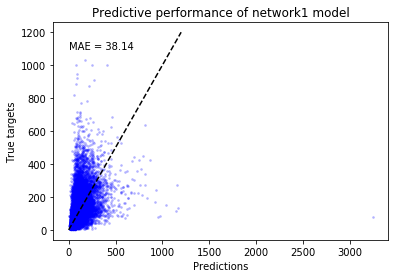

In [33]:
plot_performance(true= y_val, preds= preds, model_name= "network1")